In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import cv2
import numpy as np
import matplotlib.pyplot as plt

from src.utils.video_utils import get_video, get_frame_from_video
from src.utils.ground_utils import get_mask as get_ground_mask
from src.utils.ground_utils import get_model_from as get_ground_model_from
from src.gld_lcim.scenes_analysis import get_flow

DATA_PATH = '../data/'
GENERATED_PATH = '../generated/'
LDR_PATH = f'{DATA_PATH}ldr/'
GENERATED_MASK_PATH = f'{GENERATED_PATH}sky_cloud_segmentation/scene_masks/'

FLOW_SCALE = 50
FLOW_STEP = 15

In [3]:
ground_model_type = 'deeplabv3mobilenetv3large'
ground_model_save_path = f"{DATA_PATH}sky_ground_segmentation/models/{ground_model_type}_ranger_pretrained.pth"
ground_model = get_ground_model_from(model_save_path=ground_model_save_path, model_type=ground_model_type)

✅ Loaded pretrained model deeplabv3mobilenetv3large with 11,024,445 learnable parameters.
✅ Loaded model from ../data/sky_ground_segmentation/models/deeplabv3mobilenetv3large_ranger_pretrained.pth


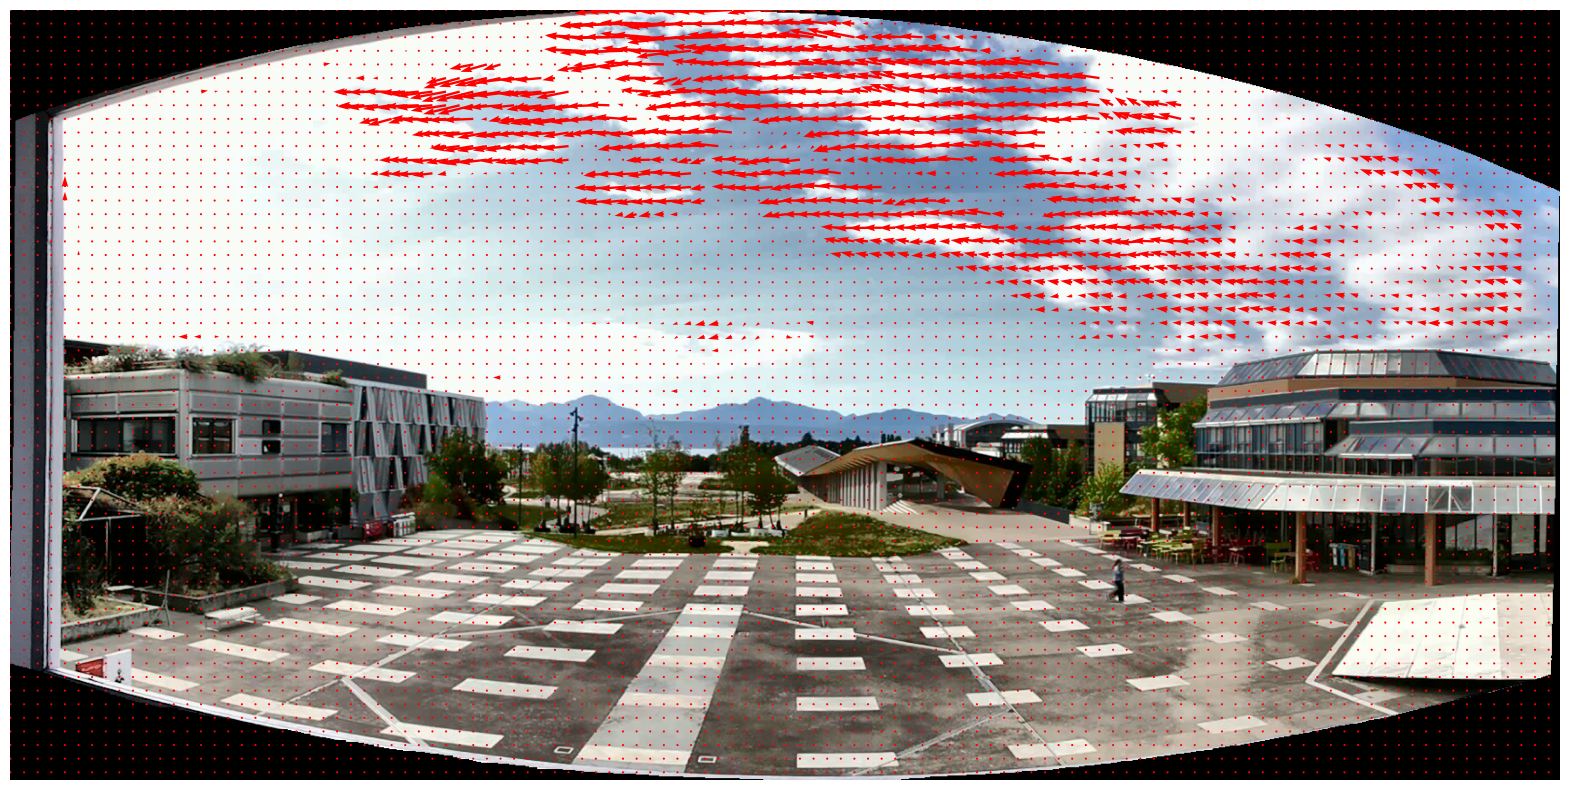

In [4]:
# Get scene frames
scene_path = f'{LDR_PATH}processed/P1Scene05.mp4'
scene_video = get_video(scene_path)
frame1, _ = get_frame_from_video(scene_video, 3, split=False, masked=True, reframed=True)
frame2, _ = get_frame_from_video(scene_video, 3 + 75, split=False, masked=True, reframed=True)
rgb_frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
rgb_frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)

# Get ground mask
scene_ground_mask = get_ground_mask(rgb_frame1 / 255, ground_model)
rgb_frame1 = rgb_frame1 * scene_ground_mask[:, :, np.newaxis]
rgb_frame2 = rgb_frame2 * scene_ground_mask[:, :, np.newaxis]

# Get l channels
l1 = rgb_frame1[:, :, 1]
l2 = rgb_frame2[:, :, 1]

# Get flow
flow = get_flow(l1, l2, mask=scene_ground_mask)
flow = flow * FLOW_SCALE

y, x = np.mgrid[0:flow.shape[0]:FLOW_STEP, 0:flow.shape[1]:FLOW_STEP]
u, v = flow[::FLOW_STEP, ::FLOW_STEP, 0], flow[::FLOW_STEP, ::FLOW_STEP, 1]

# Plot
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
ax.imshow(frame1, origin='upper')
ax.quiver(x, y, u, v, angles='xy', scale_units='xy', 
          scale=5, 
          width=0.0015,
          headlength=5,
          headwidth=3,
          headaxislength=4.5,
          color='r')
plt.axis('off')
plt.show()
